In [19]:
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
import random
import torch.nn.functional as F

In [8]:
class CustomSiameseDataset(Dataset):
    def __init__(self, dataset_path, transform=None):
        self.dataset_path = dataset_path
        self.transform = transform
        self.classes = os.listdir(dataset_path)
        self.class_images = {}
        for cls in self.classes:
            class_path = os.path.join(dataset_path, cls)
            self.class_images[cls] = [os.path.join(cls, img) for img in os.listdir(class_path)]

    def __len__(self):
        return sum(len(images) for images in self.class_images.values())

    def __getitem__(self, idx):
        similar_pair = np.random.choice([True, False])
        if similar_pair:
            cls = np.random.choice(self.classes)
            if len(self.class_images[cls]) == 1:
                img1_path = img2_path = np.random.choice(self.class_images[cls])
            else:
                img1_path, img2_path = np.random.choice(self.class_images[cls], 2, replace=False)
        else:
            cls1, cls2 = np.random.choice(self.classes, 2, replace=False)
            img1_path = np.random.choice(self.class_images[cls1])
            img2_path = np.random.choice(self.class_images[cls2])

        img1_path = os.path.join(self.dataset_path, img1_path)
        img2_path = os.path.join(self.dataset_path, img2_path)

        img1 = Image.open(img1_path).convert("L")
        img2 = Image.open(img2_path).convert("L")

        if self.transform is not None:
            img1 = self.transform(img1)
            img2 = self.transform(img2)

        label = 1 if similar_pair else 0
        return img1, img2, torch.tensor(label, dtype=torch.float32)

In [9]:
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [34]:
class Siamese(nn.Module):
    def __init__(self):
        super().__init__()
        self.convolutional = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.linear = nn.Sequential(
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(),
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
        )

    def encode(self, x):
        x = self.convolutional(x)
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        return x

    def forward(self, x1, x2):
        out1 = self.encode(x1)
        out2 = self.encode(x2)
        return out1, out2

In [35]:
def train(model, device, train_loader, criterion, optimizer, epochs=50):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for batch_idx, (img1, img2, label) in enumerate(train_loader):
            img1, img2, label = img1.to(device), img2.to(device), label.to(device)

            optimizer.zero_grad()
            output1, output2 = model(img1, img2)
            loss = criterion(output1 - output2, label.unsqueeze(1))
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f'Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}')

In [37]:
if __name__ == "__main__":
    dataset_path = '/kaggle/input/recognitionlp'
    custom_dataset = CustomSiameseDataset(dataset_path, transform=transform)
    train_loader = DataLoader(dataset=custom_dataset, shuffle=True, batch_size=64)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = Siamese().to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    train(model, device, train_loader, criterion, optimizer, epochs=50)

Epoch 1, Loss: 0.7086086049675941
Epoch 2, Loss: 0.704622033983469
Epoch 3, Loss: 0.6968292035162449
Epoch 4, Loss: 0.6988583281636238
Epoch 5, Loss: 0.6929968893527985
Epoch 6, Loss: 0.6957802288234234
Epoch 7, Loss: 0.6969842612743378
Epoch 8, Loss: 0.6992516480386257
Epoch 9, Loss: 0.6941876746714115
Epoch 10, Loss: 0.7023833990097046
Epoch 11, Loss: 0.6968352980911732
Epoch 12, Loss: 0.6976536735892296
Epoch 13, Loss: 0.6939839236438274
Epoch 14, Loss: 0.693923357874155
Epoch 15, Loss: 0.6952871754765511
Epoch 16, Loss: 0.6925478652119637
Epoch 17, Loss: 0.6933589279651642
Epoch 18, Loss: 0.6928788237273693
Epoch 19, Loss: 0.693027950823307
Epoch 20, Loss: 0.6939397603273392
Epoch 21, Loss: 0.6924596540629864
Epoch 22, Loss: 0.6980888918042183
Epoch 23, Loss: 0.6951277442276478
Epoch 24, Loss: 0.6936394013464451
Epoch 25, Loss: 0.6963181532919407
Epoch 26, Loss: 0.6945768781006336
Epoch 27, Loss: 0.6939104944467545
Epoch 28, Loss: 0.6937822997570038
Epoch 29, Loss: 0.69277000799775

In [38]:
def visualize_model_predictions_with_labels(model, device, data_loader, num_pairs=5):
    model.eval()
    fig, axes = plt.subplots(num_pairs, 2, figsize=(10, 2 * num_pairs))
    with torch.no_grad():
        for i, (img1, img2, label) in enumerate(data_loader):
            if i >= num_pairs:
                break
            img1, img2 = img1.to(device), img2.to(device)
            output1, output2 = model(img1, img2)
            for j in range(img1.size(0)):
                if j >= num_pairs:
                    break
                similarity_score = torch.sigmoid(output1[j] - output2[j]).item()
                predicted_label = 1 if similarity_score > 0.49 else 0
                img1_np, img2_np = img1[j].cpu().squeeze().numpy(), img2[j].cpu().squeeze().numpy()
                axes[j, 0].imshow(img1_np, cmap='gray')
                axes[j, 1].imshow(img2_np, cmap='gray')
                true_label = label[j].item()
                axes[j, 0].set_title(f'True: {true_label}, Pred: {predicted_label}\nScore: {similarity_score:.2f}')
                axes[j, 0].axis('off')
                axes[j, 1].axis('off')
    plt.tight_layout()
    plt.show()

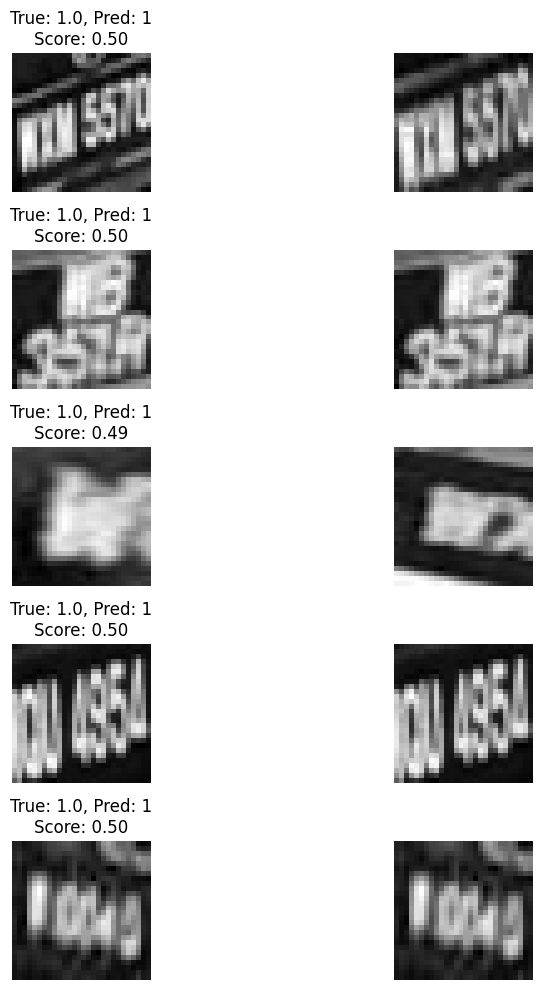

In [39]:
visualize_model_predictions_with_labels(model, device, train_loader, num_pairs=5)